In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
NUM_TRAIN = 49000
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_train = torchvision.datasets.CIFAR10("../datasets", train=True, 
                transform=transform)

cifar10_test = torchvision.datasets.CIFAR10("../datasets", train=False,
                transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=BATCH_SIZE,
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

loader_test = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
class GoogLeNet_v2(nn.Module):
    def __init__(self):
        super(GoogLeNet_v2, self).__init__()

        self.conv1 = Conv_BN_ReLU(3, 64, 7, 2, 3)

        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = nn.Sequential(
            Conv_BN_ReLU(64, 64, 1),
            Conv_BN_ReLU(64, 192, 3, padding=1)
        )

        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception_3a = Inception(192, 64, 64, 64, 64, 96, 32, "avg")

        self.inception_3b = Inception(256, 64, 64, 96, 64, 96, 64, "avg")

        self.inception_3c = Inception(320, 0, 128, 160, 64, 96, 320, "max")

        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception_4a = Inception(576, 224, 64, 96, 96, 128, 128, "avg")

        self.auxiliary_4a = Auxiliary_Classifier(576)

        self.inception_4b = Inception(576, 192, 96, 128, 96, 128, 128, "avg")

        # Output Size Wrong?
        self.inception_4c = Inception(576, 160, 128, 160, 128, 128, 128, "avg")
        # Output Size Wrong?
        self.inception_4d = Inception(576, 96, 128, 192, 160, 160, 128, "avg")

        self.auxiliary_4d = Auxiliary_Classifier(576)

        self.inception_4e = Inception(576, 0, 128, 192, 192, 256, 576, "max")

        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception_5a = Inception(1024, 352, 192, 320, 160, 224, 128, "avg")

        self.inception_5b = Inception(1024, 352, 192, 320, 192, 224, 128, "max")

        self.classification = nn.Sequential(
            nn.AvgPool2d(7, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.inception_3c(x)
        x = self.maxpool3(x)
        x = self.inception_4a(x)
        aux_1 = self.auxiliary_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        aux_2 = self.auxiliary_4d(x)
        x = self.inception_4e(x)
        x = self.maxpool4(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.classification(x)

        return x, aux_1, aux_2


class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(Conv_BN_ReLU, self).__init__()

        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.conv_bn_relu(x)


class Inception(nn.Module):
    def __init__(self, in_channel, channel_1, channel_3_r, channel_3, 
                 channel_dou3_r, channel_dou3, channel_pool, pool):
        super(Inception, self).__init__()

        self.channel_1 = channel_1
        if channel_1 != 0:
            self.conv_1x1 = Conv_BN_ReLU(in_channel, channel_1, 1)

        self.conv_3x3 = nn.Sequential(
            Conv_BN_ReLU(in_channel, channel_3_r, 3, padding=1),
            Conv_BN_ReLU(channel_3_r, channel_3, 3, padding=1)
        )

        self.conv_double_3x3 = nn.Sequential(
            Conv_BN_ReLU(in_channel, channel_dou3_r, 1),
            Conv_BN_ReLU(channel_dou3_r, channel_dou3_r, 3, padding=1),
            Conv_BN_ReLU(channel_dou3_r, channel_dou3, 3, padding=1)
        )

        if pool == "avg":
            self.conv_pool = nn.Sequential(
                nn.AvgPool2d(3, stride=1, padding=1),
                Conv_BN_ReLU(in_channel, channel_pool, 1)
            )
        elif pool == 'max':
            self.conv_pool = nn.Sequential(
                nn.MaxPool2d(3, stride=1, padding=1),
                Conv_BN_ReLU(in_channel, channel_pool, 1)
            )

    def forward(self, x):
        if self.channel_1 != 0:
            out_1 = self.conv_1x1(x)
        out_2 = self.conv_3x3(x)
        out_3 = self.conv_double_3x3(x)
        out_4 = self.conv_pool(x)

        if self.channel_1 != 0:
            out = torch.cat((out_1, out_2, out_3, out_4), dim=1)
        else:
            out = torch.cat((out_2, out_3, out_4), dim=1)

        return out


class Auxiliary_Classifier(nn.Module):
    def __init__(self, in_channel):
        super(Auxiliary_Classifier, self).__init__()

        self.classification = nn.Sequential(
            nn.AvgPool2d(5, stride=3),
            Conv_BN_ReLU(in_channel, 128, 1),
            nn.Flatten(),
            nn.Linear(4 * 4 * 128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        return self.classification(x)

In [4]:
model = GoogLeNet_v2()
input = torch.randn((2, 3, 224, 224))
output, aux_1, aux_2 = model(input)
print(input.size(), output.size(), aux_1.size(), aux_2.size())

torch.Size([2, 3, 224, 224]) torch.Size([2, 10]) torch.Size([2, 10]) torch.Size([2, 10])


In [5]:
device = torch.device('cuda')
print("Using:", device)

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores, _, _ = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        return acc

# def train_model(model, optimizer, loader=loader_train, epochs=10):
def train_model(model, optimizer, scheduler, loader=loader_train, epochs=10):
    model = model.to(device=device)
    loss_fc = nn.CrossEntropyLoss()
    loss_history = []
    acc_history = []
    for e in range(epochs):
        t1 = time.time()

        for t, (x, y) in enumerate(loader):
            model.train()
            x = x.to(device=device)
            y = y.to(device=device)

            optimizer.zero_grad()

            scores, aux_1, aux_2 = model(x)
            loss = loss_fc(scores, y) + 0.3 * (loss_fc(aux_1, y) + loss_fc(aux_2, y))

            loss.backward()
            optimizer.step()
            
        scheduler.step()

        # torch.cuda.synchronize()
        t2 = time.time()

        acc = check_accuracy(loader_val, model)
        print('Epoch {}, loss = {:.4f}, accuracy = {:.2f}%, runtime: {}s'.format(e, 
                loss.item(), acc * 100, (t2 - t1)))

        loss_history.append(loss)
        acc_history.append(acc)
    
    return loss_history, acc_history

Using: cuda


In [6]:
learning_rate = 1e-3
model = GoogLeNet_v2()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
loss_history, acc_history = train_model(model, optimizer, scheduler, epochs=5)

Epoch 0, loss = 2.4116, accuracy = 51.70%, runtime: 357.16963028907776s
Epoch 1, loss = 3.3099, accuracy = 60.90%, runtime: 358.1984272003174s
Epoch 2, loss = 2.8695, accuracy = 78.50%, runtime: 359.05804920196533s
Epoch 3, loss = 3.2864, accuracy = 79.10%, runtime: 359.46506547927856s
Epoch 4, loss = 0.8873, accuracy = 84.20%, runtime: 358.9010932445526s


Text(0.5, 1.0, 'Training Accuracy history')

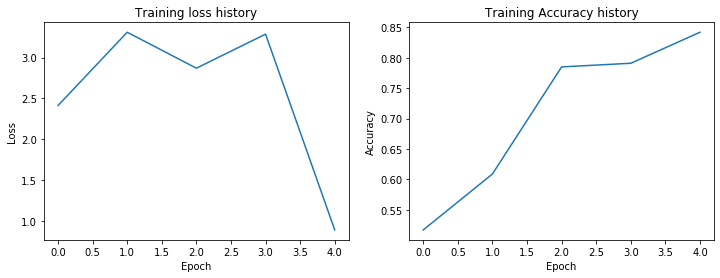

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss history')

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy history')

In [9]:
check_accuracy(loader_test, model)

0.8195